# isoration Forest 時系列異常検知

### 必要なモジュールのimport

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

### セグメントの切り出し関数

In [31]:
def segdata(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) #セグメントの切り出し，時系列反転，appendのための2次ベクトル化
        emb = np.append( emb, tmp, axis=0)
    return emb

### データ読み込み，パラメータ設定
 Keoghらの心電図のデータ  http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt
 Keogh, E., Lin, J. and Fu, A.: HOT SAX : Efficiently Finding the Most Unusual Time Series Subsequence, in Proceedings of the Fifth IEEE International Conference on Data Mining, ICDM 05, pp.226-233.

In [109]:
LEN=3000  #学習テストそれぞれの分析区間
WLEN=150 #セグメントのサイズ
SP=0         #学習用データの開始点
AP=LEN   #テスト用データの開始点　このデータの場合 1250ポイント付近(データ全体では4250ポイント)に異常がある

総データ数: 45000   次元数: 3


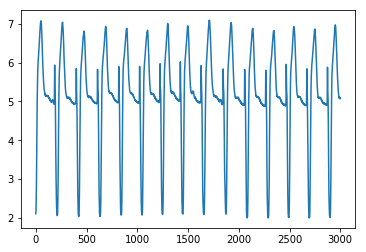

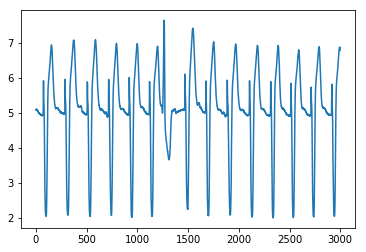

In [110]:
data = np.loadtxt("data/qtdbsel102.txt",delimiter="\t")
print("総データ数:",data.shape[0],"  次元数:",data.shape[1])

#元データは3次元の時系列，3次のデータ．
#ここでは１次元データを扱うため，index=2 のデータを取得し，これを学習/テストデータに分割
train_org = data[SP:SP+LEN, 2]  #学習用データ
test_org  = data[AP:AP+LEN, 2]  #テスト用データ

plt.plot(train_org)
plt.show()
plt.plot(test_org)
plt.show()


### 窓関数の設定と切り出し

In [111]:
seglen = WLEN   #Window size
#winlenの単位で1ポイントずつずらした2次元表現に変換
train = segdata(train_org, seglen)
test =  segdata(test_org, seglen)
print(train.shape)
print(test.shape)

(2851, 150)
(2851, 150)


## isolation Forest（学習データ）

In [112]:
outliers_fraction = 0.0001
rng = np.random.RandomState(123)
isof = IsolationForest(contamination=outliers_fraction,
                          max_samples="auto",
                          random_state=rng,
                          n_estimators=100)

isof.fit(train) #学習
score_pred = isof.decision_function(train) #判定スコア
pred = isof.predict(train) #判定
print(pred)
outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
print(outlier_rows)

[1 1 1 ... 1 1 1]
[1625]


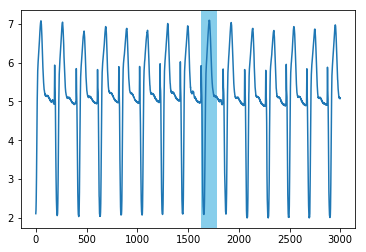

In [113]:
for c in outlier_rows:
    plt.axvspan(c, c+WLEN, color = "skyblue")
plt.plot(train_org)
plt.show()

## 未知データに対する評価

In [114]:
score_pred = isof.decision_function(test)
pred = isof.predict(test)
outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
print(outlier_rows)
    

[270, 275, 276, 277, 278, 284, 285, 286, 295, 296, 1120, 1125, 1126, 1172, 1173, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1432, 1437, 1438, 1439, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1481, 1482]


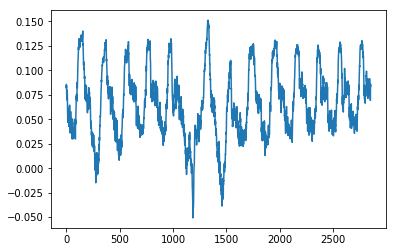

In [115]:
plt.plot(score_pred)

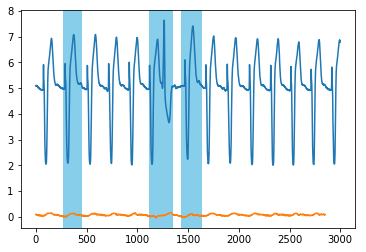

In [116]:
for c in outlier_rows:
    plt.axvspan(c, c+WLEN, color = "skyblue")
plt.plot(test_org)
plt.plot(score_pred)
plt.show()